## Methods of Representation

In [1]:
# setup the environment
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.dists import UniformHypersphere
% matplotlib inline

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

In [2]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# observed current age (i.e., t value)
x = 60

# all possible values of t_total (from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)   

# Prior porabability distribution p(t_total)
p_theta = [(st.skewnorm.pdf(p, a=-4, loc=97, scale=28)) for p in thetas]  # prior probability: p(theta)
p_theta = p_theta/np.sum(p_theta)    # normalize prior (to sum up to 1)

# likelihood function given observation that current age = x = 60
likelihood = [1/p for p in thetas]  #  p(X/theta)
likelihood[0:x-1] = [0]*(x-1)

num_neurons = 50   # number of neurons in each ensemble
dim = max_age      # number of dimensions represented by each ensemble

### Represeting using ensembles with default nengo settings

In [3]:
model = nengo.Network()
with model:
  
    # nodes to provide input to ensembles
    prior_in = nengo.Node(output=p_theta)
    likelihood_in = nengo.Node(output=likelihood)

    # ensembles representing prior and likelihood
    prior_ens = nengo.Ensemble(n_neurons=num_neurons, dimensions=dim) 
    likelihood_ens = nengo.Ensemble(n_neurons=num_neurons, dimensions=dim)
    
    # connect input to ensembles
    nengo.Connection(prior_in, prior_ens)
    nengo.Connection(likelihood_in, likelihood_ens) 

In [4]:
with model:    
    prior_p = nengo.Probe(prior_ens, synapse=0.03)
    likelihood_p = nengo.Probe(likelihood_ens, synapse=0.03)

In [5]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(0.5)  

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


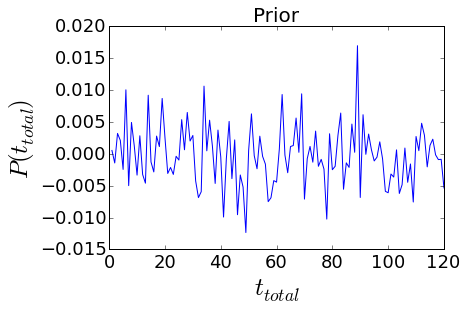

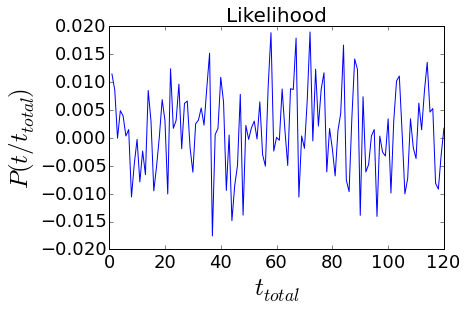

In [6]:
plt.figure()
plt.plot(thetas, sim.data[prior_p][-1])
plt.xlim(0,120)
plt.title("Prior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[likelihood_p][-1])
plt.title("Likelihood", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)

Note that the values in the above graphs are both postive and negative and the representation is pretty bad and uninterpretable

### Represeting using ensemble arrays with default nengo settings

One could also try using ensemble arrays to improve the representation and force the encoders and evaluation points to be positive in order to get only positive values for the distributions.  

In [7]:
p_theta = [100*a for a in p_theta]  # Scaling prior by a factor of 100
likelihood = [100*b for b in likelihood] #  Scaling likelihood by a factor of 100

num_neurons = 50

rng = np.random.RandomState(12) 
num_samples = 4000*5
model = nengo.Network()
with model:
  
    prior_in = nengo.Node(output=p_theta)
    likelihood_in = nengo.Node(output=likelihood)
    
    # define eval points to only represent positive values
    encoders = UniformHypersphere(surface=True).sample(num_neurons, 1, rng=rng)
    eval_points = rng.uniform(0, 1, size=(num_samples, 1))
    
    prior_ens = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=3, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0]) 
    likelihood_ens = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=3, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])
    posterior_ens = nengo.networks.EnsembleArray(n_neurons=num_neurons, n_ensembles=dim, 
                            radius=3, encoders=encoders, eval_points=eval_points, 
                            n_eval_points=eval_points.shape[0])

    nengo.Connection(prior_in, prior_ens.input)
    nengo.Connection(likelihood_in, likelihood_ens.input)   
    
    product = nengo.networks.Product(n_neurons=num_neurons*2, dimensions=dim, input_magnitude=3)
    
    nengo.Connection(likelihood_ens.output, product.A)
    nengo.Connection(prior_ens.output, product.B)
    nengo.Connection(product.output, posterior_ens.input)  

In [8]:
with model:
    posterior_p = nengo.Probe(posterior_ens.output, synapse=0.03)
    prior_p = nengo.Probe(prior_ens.output, synapse=0.03)
    likelihood_p = nengo.Probe(likelihood_ens.output, synapse=0.03)

In [9]:
sim = nengo.Simulator(model)  # Create the simulator
sim.run(1.0)                  # Run it for 1.0 seconds

Building finished in 0:00:27.                                                   
Simulating finished in 0:00:46.                                                 


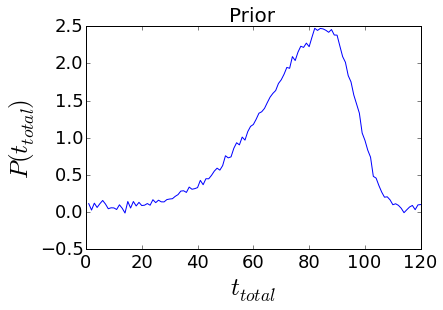

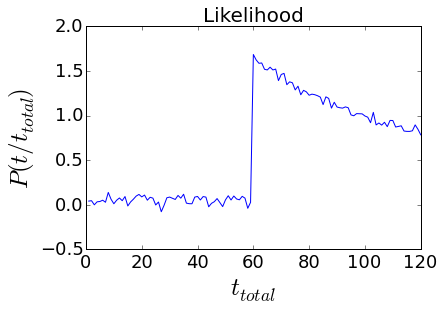

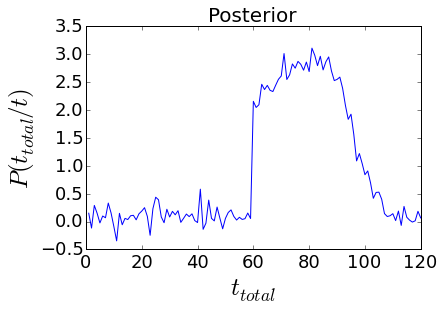

In [10]:
plt.figure()
plt.plot(thetas, sim.data[prior_p][-1])
plt.title("Prior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[likelihood_p][-1])
plt.title("Likelihood", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[posterior_p][-1])
plt.title("Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

This approach gives an approximation of the distributions only when likelihood and prior are scaled by a factor of 100. This indicates that the the neurons need to be optimized for a subsapce of values which are important for these particular distributions. Also note that the posterior will need to be normalized in order to give the correct predictions.

### Representation using subsapces and the Complete Model in Nengo

Defining a particular probability distribution is a way of limiting the space spanned by the basis $\phi(ν)$ to some subspace of interest. This is also the domain over which the optimization to find the decoders should be performed.

In [22]:
import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function

In [23]:
# prior parameters
skew = -4
loc = 97
scale = 28

# our function domain is thetas (i.e., age from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)

def likelihood(x):
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

def skew_gauss(skew, loc, scale):
    return [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 
    
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


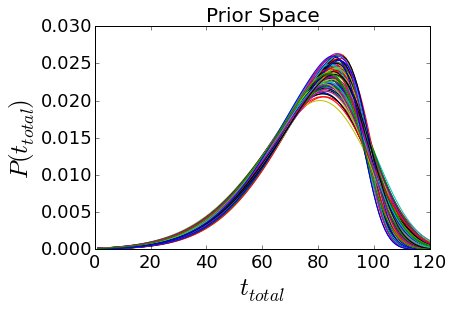

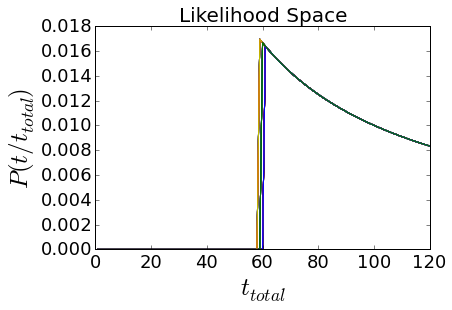

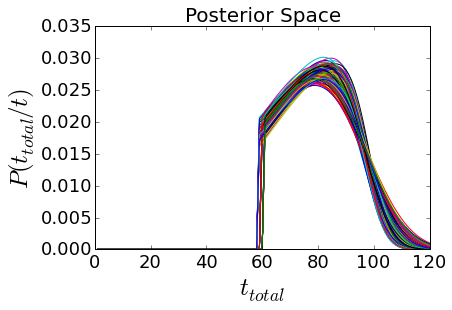

In [25]:
# DEFINE SUB-SPACES

space = []
for i in range(100):
    space.append(skew_gauss(
                          skew=np.random.uniform(skew-1, skew+2), 
                          loc=np.random.uniform(loc-1,loc+2), 
                          scale=np.random.uniform(scale-1, scale+2)))
plt.figure()    
plt.plot(thetas, np.array(space).T)
plt.title("Prior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

lik_space = []
for i in range(100):
    lik_space.append(likelihood(x=np.random.uniform(x-1,x+2)))
    
plt.figure()    
plt.plot(thetas, np.array(lik_space).T)
plt.title("Likelihood Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)


post_space = []
for i in range(100):
    post_space.append(posterior(x=np.random.uniform(x-1,x+2),
                            skew=np.random.uniform(skew-1, skew+2), 
                          loc=np.random.uniform(loc-1,loc+2), 
                          scale=np.random.uniform(scale-1, scale+2)))
plt.figure()        
plt.plot(thetas, np.array(post_space).T)
plt.title("Posterior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


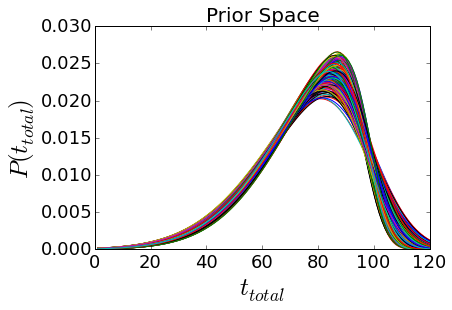

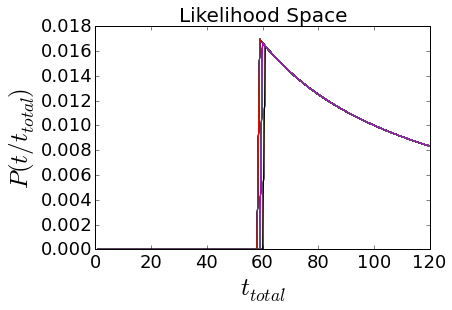

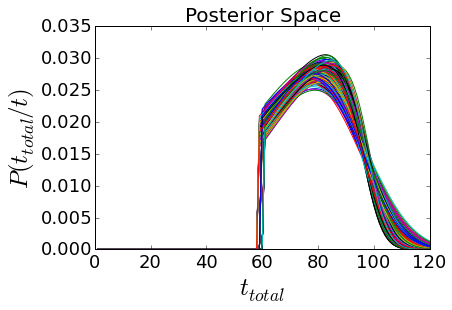

In [26]:
# DEFINE SUB-SPACES in Nengo
# but in order to integrate it with Nengo, a separate class

space = nengo.dists.Function(skew_gauss,
                             skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-1,loc+2), 
                          scale=nengo.dists.Uniform(scale-1, scale+2))
data = space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Prior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)



lik_space = nengo.dists.Function(likelihood,
                            x=nengo.dists.Uniform(x-1,x+2))
data = lik_space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.plot(thetas, likelihood(x=x))
plt.title("Likelihood Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)



post_space = nengo.dists.Function(posterior,
                             x=nengo.dists.Uniform(x-1,x+2),
                            skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-1,loc+2), 
                          scale=nengo.dists.Uniform(scale-1, scale+2))
data = post_space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Posterior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.show()

In [42]:
model = nengo.Network(seed=12)
with model:
    stim = nengo.Node(label="prior input", output=skew_gauss(skew=skew, loc=loc, scale=scale))
    ens = nengo.Ensemble(label="Prior", n_neurons=50, dimensions=dim,
                         encoders=space,
                         eval_points=space,
                        )
    
    stim2 = nengo.Node(label="likelihood input", output=likelihood(x=x))
    ens2 = nengo.Ensemble(label="Likelihood", n_neurons=50, dimensions=dim,
                         encoders=lik_space,
                         eval_points=lik_space,
                        )
    
    
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
    
    nengo.Connection(stim2, ens2)
    probe_func2 = nengo.Probe(ens2, synapse=0.03)
    
    # elementwise multiplication
    posterior = nengo.Ensemble(label="Posterior", n_neurons=50, dimensions=dim,
                             encoders=post_space,
                             eval_points=post_space,
                            )
    product = nengo.networks.Product(n_neurons=50*2, dimensions=dim, input_magnitude=1)
    
    nengo.Connection(ens, product.A)
    nengo.Connection(ens2, product.B)
    nengo.Connection(product.output, posterior)
    probe_func3 = nengo.Probe(posterior, synapse=0.03)
    
    # divisive normalization
    def normalize(a):
        return a
        total = np.sum(a)
        if total == 0:
            return 0
        return [x / total for x in a]
    
    
    norm_post = nengo.Ensemble(label="Normalized Posterior", n_neurons=250, dimensions=dim, 
                               encoders=post_space,
                             eval_points=post_space)
    
    nengo.Connection(posterior, norm_post, function=normalize)
    probe_func4 = nengo.Probe(norm_post, synapse=0.03)
    
    # prediction
    def median(b):
        med = 0
        for n in np.arange(len(b)):
            cum = sum(b[:n+1])
            if cum == 0.5 or cum > 0.5:
                med = n + 1
                break
        return int(med)

    
    prediction = nengo.Node(label="Prediction", output=None, size_in=1)
       
    nengo.Connection(norm_post, prediction, function=median, synapse=0.03)
    probe_func5 = nengo.Probe(prediction, synapse=0.03)

In [ ]:
sim = nengo.Simulator(model)
sim.run(1.0)

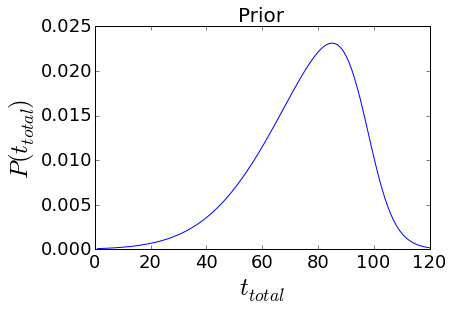

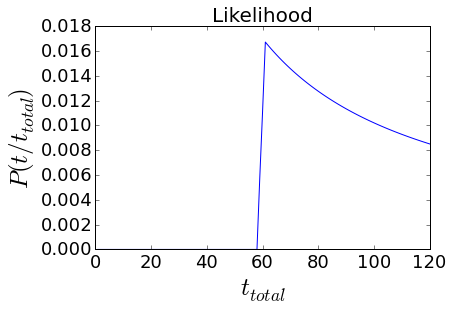

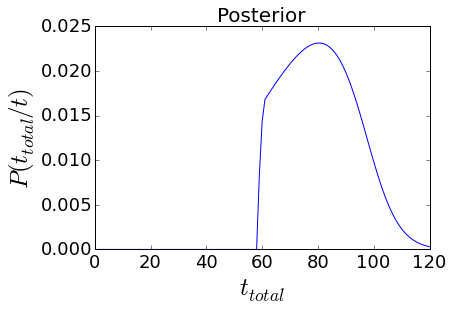

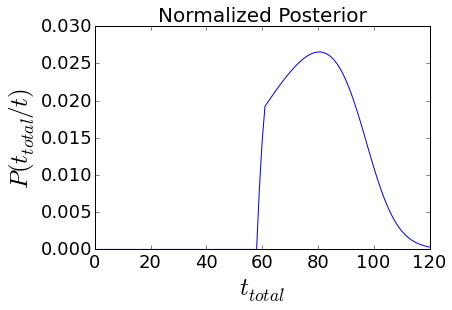

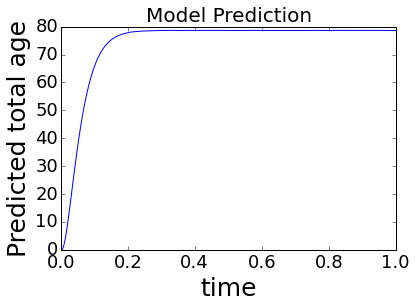

In [50]:
plt.figure()
plt.plot(thetas, sim.data[probe_func][-1])
plt.title("Prior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[probe_func2][-1])
plt.title("Likelihood", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[probe_func3][-1])
plt.title("Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[probe_func4][-1])
plt.title("Normalized Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.figure()
plt.plot(sim.trange(), sim.data[probe_func5])
plt.title("Model Prediction", fontsize=20)
plt.xlabel("time", fontsize=25)
plt.ylabel("Predicted total age", fontsize=25)

plt.show()

Note that the prediction is almost equal to 80 which is what we got from the purely computational model. However, with the neural model, the prediction is less than 80 (i.e., around 78).

In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz.load(model, "life-span_prediction.py.cfg")

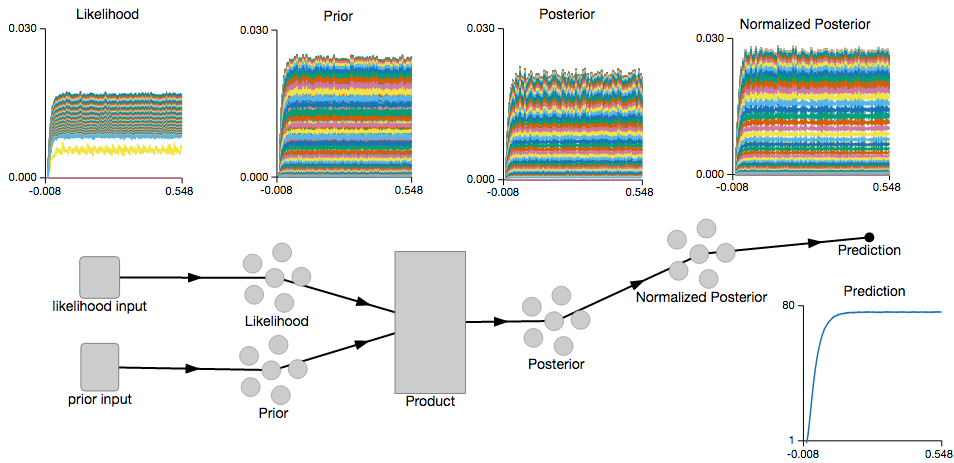

In [1]:
from IPython.display import Image
Image(filename='nengo_model.png')